**Advanced Lane Finding Project**

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import os
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

out_dir='output_images/image_processing/'

# load pickled distortion matrix
with open('calibration.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

In [2]:
# Visualize & plot
def visualizeResult(original, transformed, originalText, transformedText, originalGray=False, transformedGray=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)

    ax1.set_title(originalText, fontsize=20)
    ax2.set_title(transformedText, fontsize=20)
    
    if originalGray==True:
        ax1.imshow(original, cmap='gray')
    else:
        ax1.imshow(original)
        
    if transformedGray==True:
        ax2.imshow(transformed, cmap='gray')
    else:
        ax2.imshow(transformed)

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store objects points and image points  from all the images
objpoints = []
imgpoints = []

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), (7,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # x,y  coordinates

# fig, axs = plt.subplots(5,4, figsize=(16, 11))
# fig.subplots_adjust(hspace = .2, wspace=.001)
# axs = axs.ravel()

for i, fname in enumerate(images):
    # Read in calibration image
    img = mpimg.imread(fname)
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # axs[i].axis('off')
        # axs[i].imshow(img)

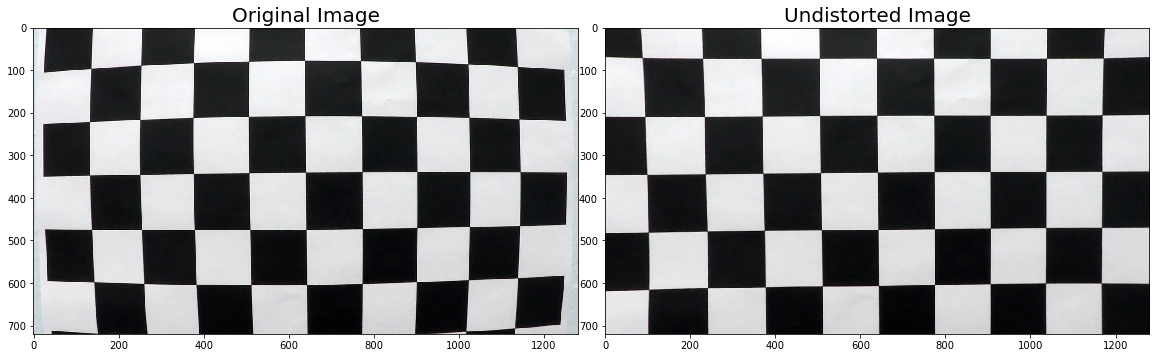

In [4]:
calImg = cv2.imread('camera_cal/calibration1.jpg')
calImg_size = (calImg.shape[1], calImg.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, calImg_size, None, None)
calUndistImg = cv2.undistort(calImg, mtx, dist, None, mtx)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )

visualizeResult(calImg, calUndistImg, 'Original Image', 'Undistorted Image')

## 2. Apply a distortion correction to raw images

In [5]:
def readImage(fname):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

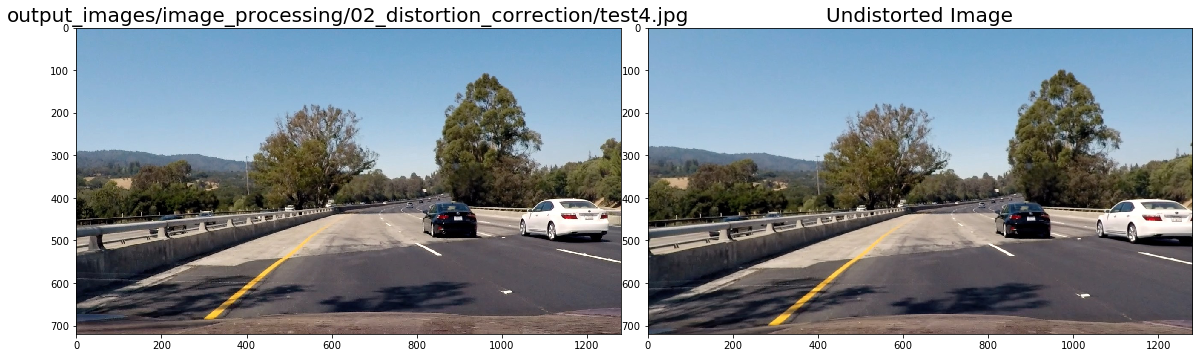

In [6]:
# load pickled distortion matrix
with open('calibration.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
        
imgPaths = glob.glob('test_images/test4.jpg')

for i, fname in enumerate(imgPaths):
    img = readImage(fname)
    # undistort image using camera calibration matrix
    undistImg = cv2.undistort(img, mtx, dist, None, mtx)

    name = out_dir + '02_distortion_correction/' + fname.split('/')[-1]
    plt.imsave(name,undistImg)
    
    visualizeResult(img, undistImg, name, 'Undistorted Image')

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [7]:
def undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

def threshold(img, s_thresh=(100, 255), g_thresh = (150, 255)):
    img = np.copy(img)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    g_binary = np.zeros_like(gray)
    g_binary[(gray > g_thresh[0]) & (gray <= g_thresh[1])] = 1
    
    # Threshold color channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)    
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    combined = np.zeros_like(s_channel)
    combined[(s_binary == 1) & (g_binary == 1)] = 1
    #combined = 255*np.dstack((combined,combined,combined)).astype('uint8')  
    return combined

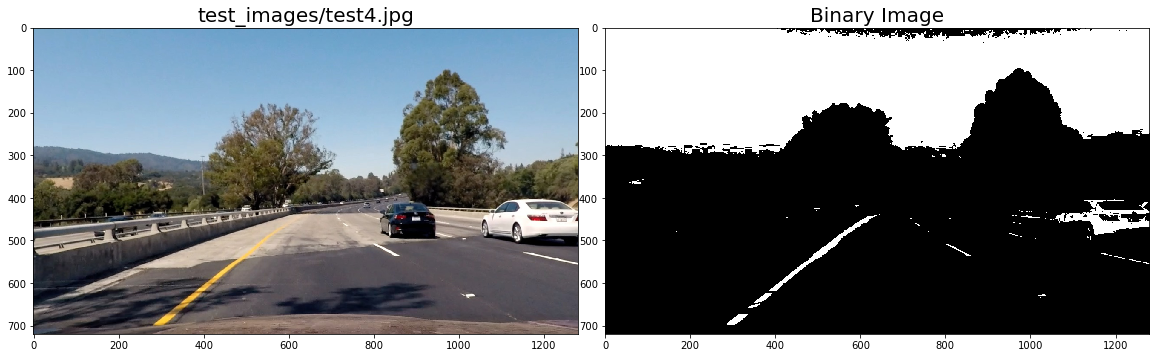

In [8]:
for i, fname in enumerate(imgPaths):
    img = readImage(fname)
    undistImg = undistort(img)
    binaryImg = threshold(undistImg)
    result = 255*np.dstack((binaryImg,binaryImg,binaryImg)).astype('uint8')  
    
    name = out_dir + '03_binary_image/' + fname.split('/')[-1]
    plt.imsave(name,result)
    
    visualizeResult(undistImg, result, fname, 'Binary Image', transformedGray=False)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [9]:
# Define  perspective  transform  function
def warp(undistImg, binaryImg):
    # Define calibration box in source (original) and destination (desird or warped) coordinates
    h,w = undistImg.shape[:2]
    
    src = np.float32([(575,464),
                      (707,464), 
                      (258,682), 
                      (1049,682)])
    dst = np.float32([(450,0),
                      (w-450,0),
                      (450,h),
                      (w-450,h)])
    
    # compute the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse perspective trandef region_of_interest(img):
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(binaryImg, M, (w,h), flags=cv2.INTER_LINEAR)
    
    return warped, Minv

In [10]:
def pipeline(img):
    undistImg = undistort(img)
    binaryImg = threshold(undistImg)
    binaryWarpedImg, Minv = warp(undistImg, binaryImg)
    return binaryWarpedImg, Minv

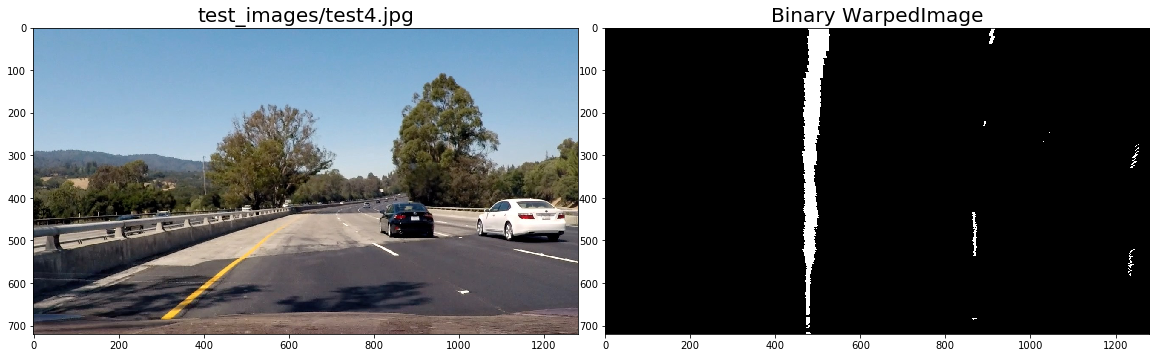

In [11]:
for i, fname in enumerate(imgPaths):
    img = readImage(fname)
    binaryWarpedImg, Minv = pipeline(img)
    result = 255*np.dstack((binaryWarpedImg,binaryWarpedImg,binaryWarpedImg)).astype('uint8')  
    
    name = out_dir + '04_binary_warped/' + fname.split('/')[-1]
    plt.imsave(name, result)
    
    visualizeResult(img, result, fname, 'Binary WarpedImage', transformedGray=True)

## 5. Detect lane pixels and fit to find the lane boundary.

### Sliding window polyfit

In [12]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

In [13]:
def plotLaneLineFit(binaryWarpedImg, result, left_fitx, right_fitx, ploty, fname):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    ax1.set_title(fname, fontsize=20)
    ax1.imshow(binaryWarpedImg, cmap='gray')
    ax2.imshow(result)
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')

In [14]:
 def laneLineFit(binaryWarpedImg, left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data, fname):
    margin = 80
    # Generate x and y values for plotting
    ploty = np.linspace(0, binaryWarpedImg.shape[0]-1, binaryWarpedImg.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.uint8(np.dstack((binaryWarpedImg, binaryWarpedImg, binaryWarpedImg))*255)
    window_img = np.zeros_like(out_img)

    # Color in left and right line pixels
    nonzero = binaryWarpedImg.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area (OLD FIT)
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty

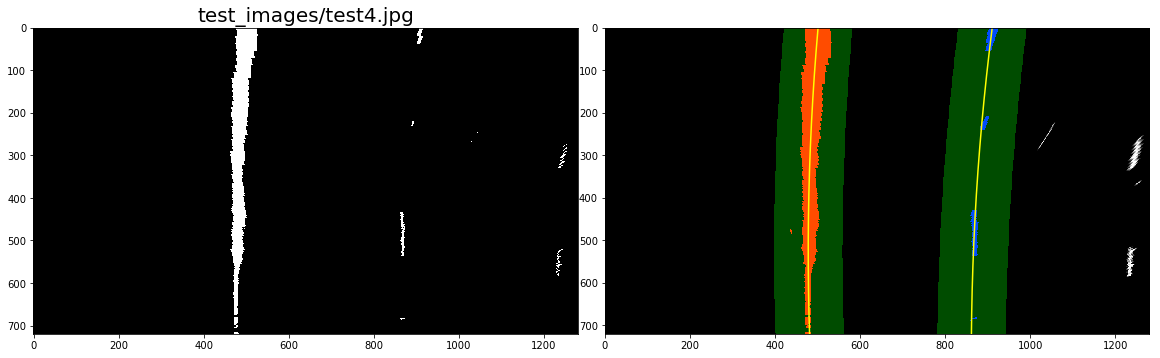

In [15]:
for i, fname in enumerate(imgPaths):
    img = readImage(fname)
    binaryWarpedImg, Minv = pipeline(img)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(binaryWarpedImg)
    result, left_fitx, right_fitx, ploty = laneLineFit(binaryWarpedImg, left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data, fname)
    
    name = out_dir + '05_binary_warped_fit/' + fname.split('/')[-1]
    binaryWarpedImg = 255*np.dstack((binaryWarpedImg,binaryWarpedImg,binaryWarpedImg)).astype('uint8')  
    plt.imsave(name,binaryWarpedImg)
    plotLaneLineFit(binaryWarpedImg, result, left_fitx, right_fitx, ploty, fname)

### Polyfit Using Fit from Previous Frame

In [16]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

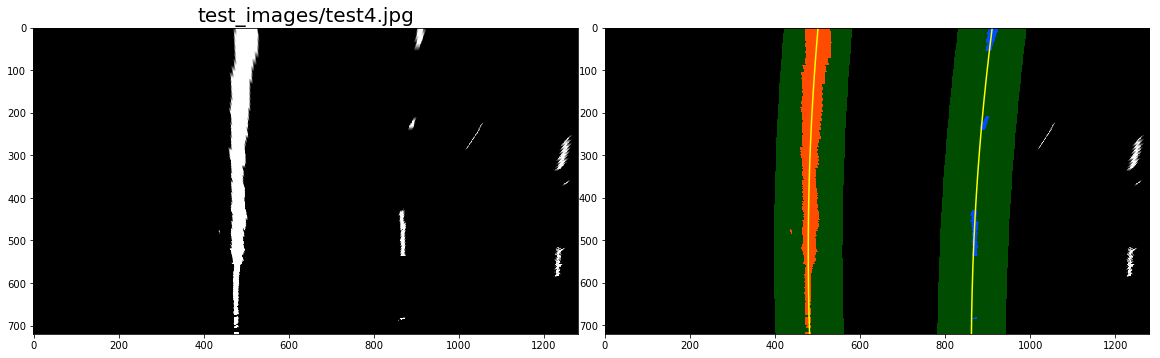

In [17]:
for i, fname in enumerate(imgPaths):

    img = readImage(fname)
    binaryWarpedImg, Minv = pipeline(img)
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(binaryWarpedImg)
    left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_using_prev_fit(binaryWarpedImg, left_fit, right_fit)

    result, left_fitx, right_fitx, ploty = laneLineFit(binaryWarpedImg, left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data, fname)
    
    plotLaneLineFit(binaryWarpedImg, result, left_fitx, right_fitx, ploty, fname)

### 6. Determine the curvature of the lane and vehicle position with respect to center.

In [18]:
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [19]:
for i, fname in enumerate(imgPaths):
    margin = 80
    img = readImage(fname)
    binaryWarpedImg, Minv = pipeline(img)
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(binaryWarpedImg)
    rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(binaryWarpedImg, left_fit, right_fit, left_lane_inds, right_lane_inds)

    name = fname.split('/')[-1]
    print('name= ' + name)
    print('Radius of curvature = ', rad_l, 'm,', rad_r, 'm')
    print('Distance from lane center = ', d_center, 'm')
    print('')

name= test4.jpg
Radius of curvature =  567.521528532 m, 575.317182606 m
Distance from lane center =  -0.307553823532 m



## 7. Warp the detected lane boundaries back onto the original image.

In [20]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)



In [21]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

In [22]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [23]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    return img_out

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

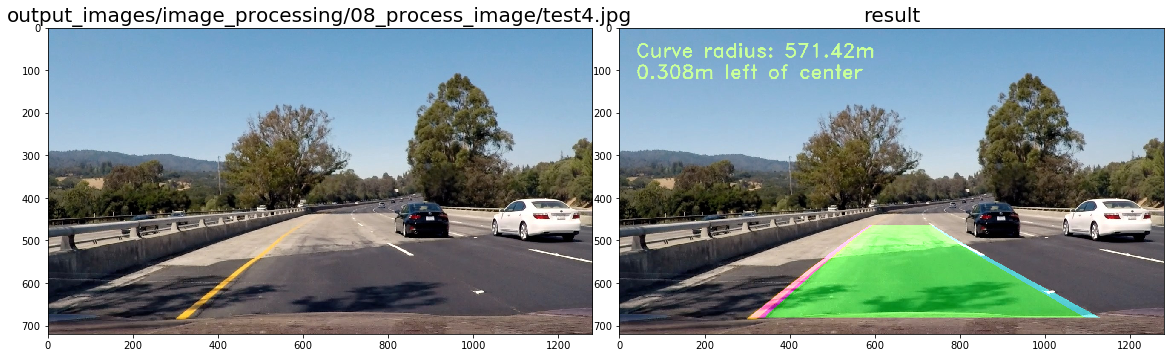

In [24]:
l_line = Line()
r_line = Line()

for i, fname in enumerate(imgPaths):
    img = readImage(fname)
    result = process_image(img)
   
    name = out_dir + '08_process_image/' + fname.split('/')[-1]
    plt.imsave(name, result)
    
    visualizeResult(img, result, name, 'result', transformedGray=False)


### Process Project Video

In [25]:
l_line = Line()
r_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:51<00:00, 11.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 1min 51s
